In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
random_seed = 42

gamma = 0.01

In [3]:
np.random.seed(random_seed)

### Helper functions

In [4]:
def true_cond_mean(x, theta, tau=0):
    beta = theta * (np.ones(5) / np.sqrt(5))
    EYX = tau + x.dot(beta)
    return EYX

def sample_dgp(n, theta, tau=0):
    eff_ind = np.random.binomial(1, 0.5, size=n)
    X_eff = np.abs(np.random.normal(size=(n,5)))
    X = eff_ind.reshape(-1,1) * X_eff
    EYX = true_cond_mean(X, theta, tau)
    Y = EYX + np.random.normal(size=n)
    return X, Y

def ttest(y, alpha):
    tstat = np.sqrt(y.shape[0]) * (y.mean() / y.std())
    rejected = (tstat > scipy.stats.norm.ppf(1 - alpha))
    return rejected

def calc_region_metrics(region_fn, theta, tau=0, n_sims=10000):
    X, Y = sample_dgp(n_sims, theta, tau)
    EYX = true_cond_mean(X, theta, tau)
    region_indic = region_fn(X)
    utility = (EYX * region_indic).mean()
    if region_indic.sum() < 2:
        base_t = -np.inf
    else:
        varsize = Y[region_indic].var() * region_indic.mean()
        base_t = utility / np.sqrt(varsize)
    return utility, base_t

def calc_asymptotic_exp_utility(region_fn, theta, n_test, tau=0, alpha=0.05):
    utility, base_t = calc_region_metrics(region_fn, theta, tau)
    z = scipy.stats.norm.ppf(1 - alpha)
    power = scipy.stats.norm.cdf(base_t * np.sqrt(n_test) - z)
    return utility * power, utility, power

def calc_empirical_exp_utility(region_fn, theta, n_test, tau=0, alpha=0.05, n_sims=1000):
    utility, _ = calc_region_metrics(region_fn, theta, tau)
    all_rejected = []
    for _ in range(n_sims):
        X, Y = sample_dgp(n_test, theta, tau)
        region_indic = region_fn(X)
        if region_indic.sum() < 2:
            rejected = False
        else:
            rejected = ttest(Y[region_indic], alpha=alpha)
        all_rejected.append(rejected)
    power = np.mean(all_rejected)
    return utility * power, utility, power

def estimate_empirical_exp_utility(X, Y, score_fn, thresholds, n_test, alpha=0.05):
    # Calculate terms
    all_utility = []
    all_base_t = []
    for thresh in thresholds:
        region_fn = lambda x: score_fn(x) > thresh
        region_indic = region_fn(X)
        utility = (Y * region_indic).mean()
        if region_indic.sum() < 10:
            base_t = -np.inf
        else:
            varsize = Y[region_indic].var() * region_indic.mean()
            base_t = utility / np.sqrt(varsize)
        all_utility.append(utility)
        all_base_t.append(base_t)
    all_utility = np.array(all_utility)
    all_base_t = np.array(all_base_t)
    # Calculate expected utility
    z = scipy.stats.norm.ppf(1 - alpha)
    all_power = scipy.stats.norm.cdf(all_base_t * np.sqrt(n_test) - z)
    all_exp_utility = all_utility * all_power
    return all_exp_utility

def bootstrap_empirical_exp_utility(X, Y, score_fn, thresholds, n_test, alpha=0.05, n_boots=200):
    # Point estimate
    exp_utility = estimate_empirical_exp_utility(X, Y, score_fn, thresholds, n_test, alpha=alpha)
    # Bootstrap estimates
    all_boot_exp_utility = []
    for _ in range(n_boots):
        boot_ids = np.random.choice(len(Y), len(Y), replace=True)
        X_boot, Y_boot = X[boot_ids], Y[boot_ids]
        boot_exp_utility = estimate_empirical_exp_utility(X_boot,
                                                          Y_boot,
                                                          score_fn,
                                                          thresholds,
                                                          n_test,
                                                          alpha=alpha)
        all_boot_exp_utility.append(boot_exp_utility)
    all_boot_exp_utility = np.array(all_boot_exp_utility)
    # # Calculate ses and drop thresholds that have no variance
    # boot_ses = np.std(all_boot_exp_utility, axis=0)
    # keep_inds = ~np.isclose(boot_ses, 0)
    # # Calculate max-t stats
    # tstats = (all_boot_exp_utility[:,keep_inds] - exp_utility[keep_inds]) / boot_ses[keep_inds]
    # maxt = tstats.max(axis=1)
    # q = np.quantile(maxt, 1 - alpha)
    # # Calculate LCB
    # lcb = exp_utility - q * boot_ses
    return exp_utility, all_boot_exp_utility

In [5]:
def soft_argmax(
    f_vals,
    grid,
    tau,
    sigma=1.0,
):
    """
    Soft arg-max with a Gaussian prior centred at 0.

    Parameters
    ----------
    f_vals : (N,) or (M, N) array_like
        Function values.  1-D ⇒ single curve; 2-D ⇒ one curve per row.
    grid   : (N,) or (M, N) or (M, N, d) array_like
        Grid locations x_j.  If 1-D, the same grid is reused for every row.
        For multidimensional points supply shape (M, N, d).
    tau    : float  (> 0)
        Temperature; smaller τ → closer to the hard arg-max.
    sigma  : float  (> 0), default 1.0
        Std-dev of the Gaussian prior N(0, σ²).

    Returns
    -------
    x_soft : float  or  (M,) ndarray  or  (M, d) ndarray
        Location(s) of the soft arg-max.
        • scalar if f_vals is 1-D and grid is 1-D
        • (M,) if grid has scalars per point
        • (M, d) if each grid point is d-dimensional
    """
    if tau <= 0:
        raise ValueError("tau must be positive")
    if sigma <= 0:
        raise ValueError("sigma must be positive")

    f = np.asarray(f_vals, dtype=float)
    g = np.asarray(grid,   dtype=float)

    # ---- reshape to 2-D in the "curve" dimension -------------------------
    scalar_input = (f.ndim == 1)
    if scalar_input:
        f = f[None, :]                     # (1, N)

    if g.ndim == 1:                       # shared 1-D grid
        if g.size != f.shape[1]:
            raise ValueError("grid length must match f_vals' columns")
        g = np.broadcast_to(g, f.shape)    # (M, N)
        grid_vec = False
    elif g.shape[:2] == f.shape:
        grid_vec = (g.ndim == 3)           # True if (M, N, d)
    else:
        raise ValueError("grid must be (N,) or broadcast-compatible with f_vals")

    # ---- Gaussian prior weights μ_i = exp(-‖x_i‖² / (2σ²)) ---------------
    if grid_vec:                           # multi-dimensional x
        dist2 = (g ** 2).sum(axis=-1)      # (M, N)
    else:                                  # scalar x
        dist2 = g ** 2                     # (M, N)
    mu = np.exp(-dist2 / (2.0 * sigma**2))

    # ---- soft-max weights with prior (numerically stable) ----------------
    f_shift = (f - f.max(axis=1, keepdims=True)) / tau
    w = mu * np.exp(f_shift)               # unnormalised
    w /= w.sum(axis=1, keepdims=True)      # row-normalise

    # ---- weighted average of grid points ---------------------------------
    if grid_vec:                           # (M, N, d)
        x_soft = (w[..., None] * g).sum(axis=1)   # (M, d)
    else:                                  # scalar grid
        x_soft = (w * g).sum(axis=1)              # (M,)

    return x_soft[0] if scalar_input else x_soft

### Check asymptotic expected utility

Thresholding true regression function

In [6]:
theta = 0.2
thresh_space = [-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6]
n_test = 100

In [7]:
all_asy_utility = []
all_emp_utility = []
for thresh in thresh_space:
    print("Processing thresh = {}".format(thresh))
    region_fn = lambda x: true_cond_mean(x, theta) > thresh
    asy_utility, _, _ = calc_empirical_exp_utility(region_fn, theta, n_test)
    emp_utility, _, _ = calc_asymptotic_exp_utility(region_fn, theta, n_test)
    all_asy_utility.append(asy_utility)
    all_emp_utility.append(emp_utility)
all_asy_utility = np.array(all_asy_utility)
all_emp_utility = np.array(all_emp_utility)

Processing thresh = -0.1
Processing thresh = 0
Processing thresh = 0.1
Processing thresh = 0.2
Processing thresh = 0.3
Processing thresh = 0.4
Processing thresh = 0.5
Processing thresh = 0.6


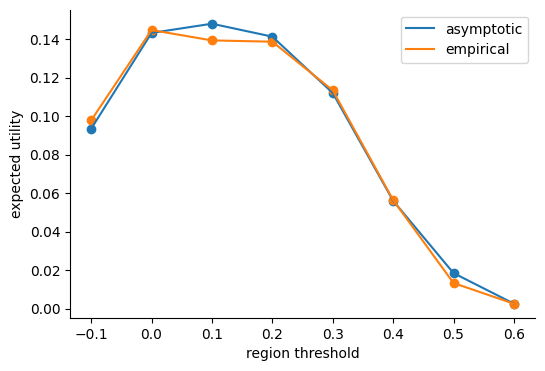

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(thresh_space, all_asy_utility, label="asymptotic")
ax.scatter(thresh_space, all_asy_utility)

ax.plot(thresh_space, all_emp_utility, label="empirical")
ax.scatter(thresh_space, all_emp_utility)

ax.set_xlabel("region threshold")
ax.set_ylabel("expected utility")

ax.spines[['right', 'top']].set_visible(False)
ax.legend()

plt.show()

Thresholding some other regression function

In [9]:
all_asy_utility = []
all_emp_utility = []
for thresh in thresh_space:
    print("Processing thresh = {}".format(thresh))
    region_fn = lambda x: (x[:,0] + x[:,1]) / np.sqrt(2) > thresh
    asy_utility, _, _ = calc_empirical_exp_utility(region_fn, theta, n_test)
    emp_utility, _, _ = calc_asymptotic_exp_utility(region_fn, theta, n_test)
    all_asy_utility.append(asy_utility)
    all_emp_utility.append(emp_utility)
all_asy_utility = np.array(all_asy_utility)
all_emp_utility = np.array(all_emp_utility)

Processing thresh = -0.1
Processing thresh = 0
Processing thresh = 0.1
Processing thresh = 0.2
Processing thresh = 0.3
Processing thresh = 0.4
Processing thresh = 0.5
Processing thresh = 0.6


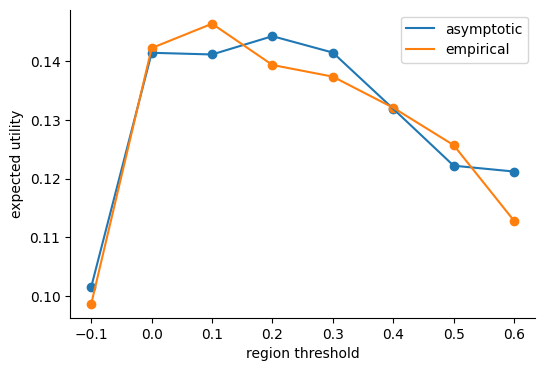

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(thresh_space, all_asy_utility, label="asymptotic")
ax.scatter(thresh_space, all_asy_utility)

ax.plot(thresh_space, all_emp_utility, label="empirical")
ax.scatter(thresh_space, all_emp_utility)

ax.set_xlabel("region threshold")
ax.set_ylabel("expected utility")

ax.spines[['right', 'top']].set_visible(False)
ax.legend()

plt.show()

Notes:
- We find that asymptotic expected utility and empirical expected utility closely matches for reasonable sample sizes.

### Investigate the properties of the empirical expected utility function

#### Heterogeneous

In [11]:
theta = 0.1
thresh_space = np.linspace(-0.1,0.2,50)
n_test = 250

score_fn = lambda x: true_cond_mean(x, theta)

In [12]:
# Calculate the truth
all_asy_utility = []
for thresh in thresh_space:
    print("Processing thresh = {}".format(thresh))
    region_fn = lambda x: true_cond_mean(x, theta) > thresh
    asy_utility, _, _ = calc_empirical_exp_utility(region_fn, theta, n_test)
    all_asy_utility.append(asy_utility)
all_asy_utility = np.array(all_asy_utility)

Processing thresh = -0.1
Processing thresh = -0.09387755102040816
Processing thresh = -0.08775510204081632
Processing thresh = -0.0816326530612245
Processing thresh = -0.07551020408163266
Processing thresh = -0.06938775510204082
Processing thresh = -0.06326530612244899
Processing thresh = -0.05714285714285715
Processing thresh = -0.05102040816326531
Processing thresh = -0.044897959183673466
Processing thresh = -0.03877551020408163
Processing thresh = -0.0326530612244898
Processing thresh = -0.026530612244897958
Processing thresh = -0.020408163265306117
Processing thresh = -0.01428571428571429
Processing thresh = -0.00816326530612245
Processing thresh = -0.002040816326530609
Processing thresh = 0.004081632653061232
Processing thresh = 0.010204081632653073
Processing thresh = 0.0163265306122449
Processing thresh = 0.02244897959183674
Processing thresh = 0.02857142857142858
Processing thresh = 0.03469387755102041
Processing thresh = 0.04081632653061226
Processing thresh = 0.04693877551020

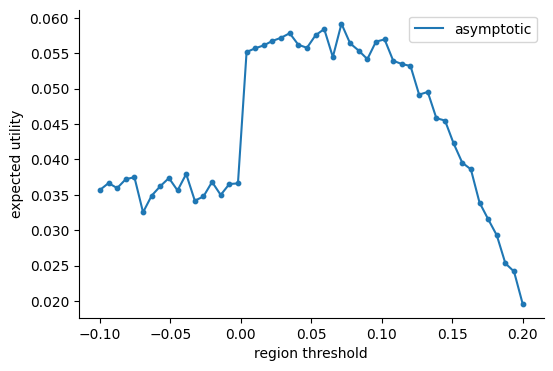

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(thresh_space, all_asy_utility, label="asymptotic")
ax.scatter(thresh_space, all_asy_utility, s=10)

ax.set_xlabel("region threshold")
ax.set_ylabel("expected utility")

ax.spines[['right', 'top']].set_visible(False)
ax.legend()

plt.show()

Large sample properties

In [14]:
n = 10000

In [15]:
X, Y = sample_dgp(n, theta)

In [16]:
exp_utility, all_boot_exp_utility = bootstrap_empirical_exp_utility(X,
                                                                    Y,
                                                                    score_fn,
                                                                    thresh_space,
                                                                    n_test)

In [17]:
opt_thresh = thresh_space[np.argmax(exp_utility)]
boot_opt_threshes = thresh_space[all_boot_exp_utility.argmax(axis=1)]
softmax_opt_thresh = soft_argmax(exp_utility, thresh_space, gamma * exp_utility.std())
boot_softmax_opt_thresh = soft_argmax(all_boot_exp_utility, thresh_space, gamma * exp_utility.std())

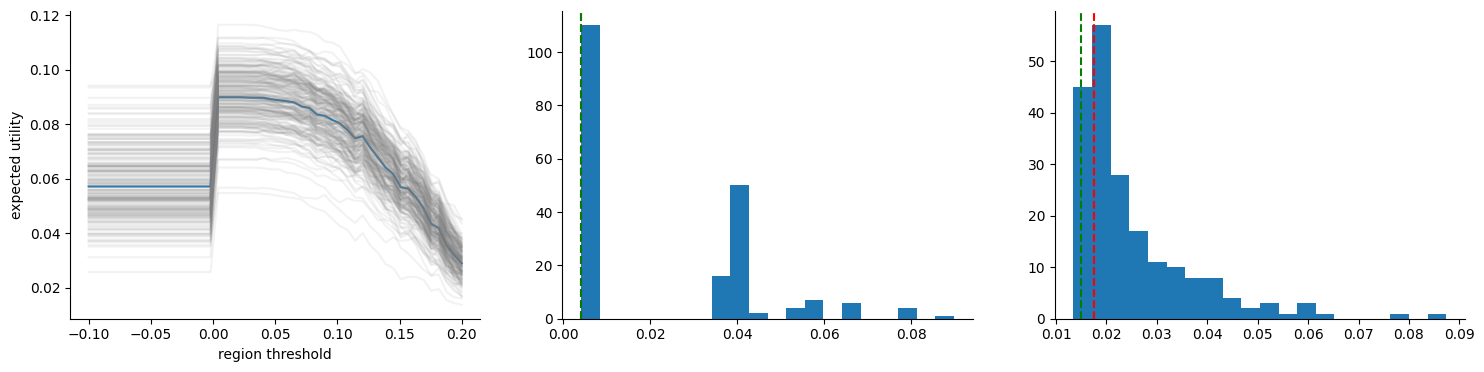

In [18]:
fig, ax = plt.subplots(1,3,figsize=(18,4))

ax[0].plot(thresh_space, exp_utility)
for boot_exp_utility in all_boot_exp_utility:
    ax[0].plot(thresh_space, boot_exp_utility, alpha=0.1, color="gray")

ax[0].set_xlabel("region threshold")
ax[0].set_ylabel("expected utility")
ax[0].spines[['right', 'top']].set_visible(False)

ax[1].hist(boot_opt_threshes, bins=20)
ax[1].axvline(opt_thresh, linestyle="--", color="red")
ax[1].axvline(np.quantile(boot_opt_threshes, 0.1), linestyle="--", color="green")
ax[1].spines[['right', 'top']].set_visible(False)

ax[2].hist(boot_softmax_opt_thresh, bins=20)
ax[2].axvline(softmax_opt_thresh, linestyle="--", color="red")
ax[2].axvline(np.quantile(boot_softmax_opt_thresh, 0.1), linestyle="--", color="green")
ax[2].spines[['right', 'top']].set_visible(False)

plt.show()

Small sample properties

In [19]:
n = 250

In [20]:
X, Y = sample_dgp(n, theta)

In [21]:
exp_utility, all_boot_exp_utility = bootstrap_empirical_exp_utility(X,
                                                                    Y,
                                                                    score_fn,
                                                                    thresh_space,
                                                                    n_test)

In [22]:
opt_thresh = thresh_space[np.argmax(exp_utility)]
boot_opt_threshes = thresh_space[all_boot_exp_utility.argmax(axis=1)]
softmax_opt_thresh = soft_argmax(exp_utility, thresh_space, gamma * exp_utility.std())
boot_softmax_opt_thresh = soft_argmax(all_boot_exp_utility, thresh_space, gamma * exp_utility.std())

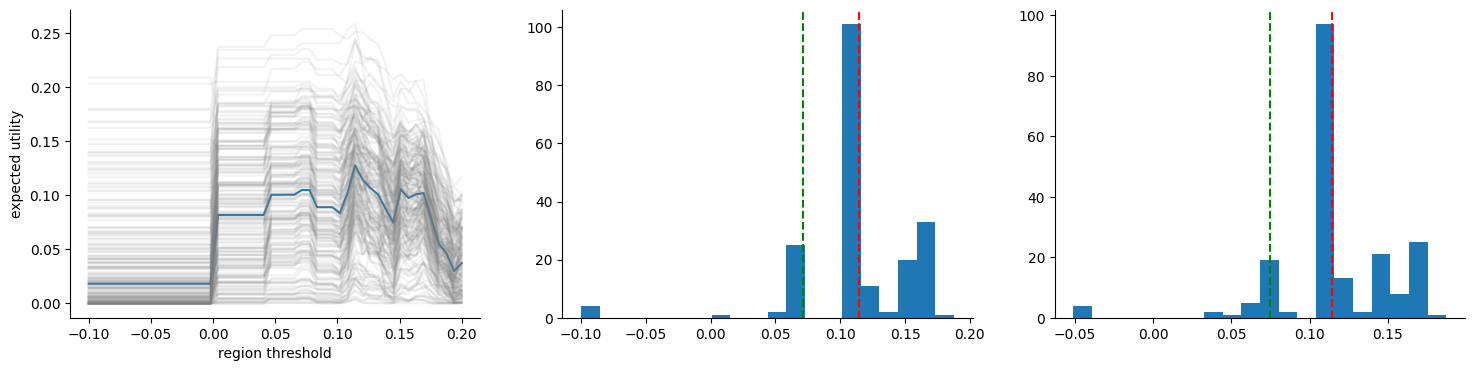

In [23]:
fig, ax = plt.subplots(1,3,figsize=(18,4))

ax[0].plot(thresh_space, exp_utility)
for boot_exp_utility in all_boot_exp_utility:
    ax[0].plot(thresh_space, boot_exp_utility, alpha=0.1, color="gray")

ax[0].set_xlabel("region threshold")
ax[0].set_ylabel("expected utility")
ax[0].spines[['right', 'top']].set_visible(False)

ax[1].hist(boot_opt_threshes, bins=20)
ax[1].axvline(opt_thresh, linestyle="--", color="red")
ax[1].axvline(np.quantile(boot_opt_threshes, 0.1), linestyle="--", color="green")
ax[1].spines[['right', 'top']].set_visible(False)

ax[2].hist(boot_softmax_opt_thresh, bins=20)
ax[2].axvline(softmax_opt_thresh, linestyle="--", color="red")
ax[2].axvline(np.quantile(boot_softmax_opt_thresh, 0.1), linestyle="--", color="green")
ax[2].spines[['right', 'top']].set_visible(False)

plt.show()

Small sample properties (distributional)

In [24]:
all_opt_threshes = []
all_lcb_opt_threshes = []
all_softmax_opt_threshes = []
all_softmax_lcb_opt_threshes = []
for _ in range(200):
    if _ % 10 == 0:
        print("Progress = {}".format(_))
    X, Y = sample_dgp(n, theta)
    exp_utility, all_boot_exp_utility = bootstrap_empirical_exp_utility(X,
                                                                        Y,
                                                                        score_fn,
                                                                        thresh_space,
                                                                        n_test)
    # Calculate optima
    opt_thresh = thresh_space[np.argmax(exp_utility)]
    boot_opt_threshes = thresh_space[all_boot_exp_utility.argmax(axis=1)]
    # Calculate softmax optima
    softmax_opt_thresh = soft_argmax(exp_utility, thresh_space, gamma * exp_utility.std())
    boot_softmax_opt_thresh = soft_argmax(all_boot_exp_utility, thresh_space, gamma * exp_utility.std())
    # Save
    all_opt_threshes.append(opt_thresh)
    all_lcb_opt_threshes.append(np.quantile(boot_opt_threshes, 0.1))
    all_softmax_opt_threshes.append(softmax_opt_thresh)
    all_softmax_lcb_opt_threshes.append(np.quantile(boot_softmax_opt_thresh, 0.1))
all_opt_threshes = np.array(all_opt_threshes)
all_lcb_opt_threshes = np.array(all_lcb_opt_threshes)
all_softmax_opt_threshes = np.array(all_softmax_opt_threshes)
all_softmax_lcb_opt_threshes = np.array(all_softmax_lcb_opt_threshes)

Progress = 0
Progress = 10
Progress = 20
Progress = 30
Progress = 40
Progress = 50
Progress = 60
Progress = 70
Progress = 80
Progress = 90
Progress = 100
Progress = 110
Progress = 120
Progress = 130
Progress = 140
Progress = 150
Progress = 160
Progress = 170
Progress = 180
Progress = 190


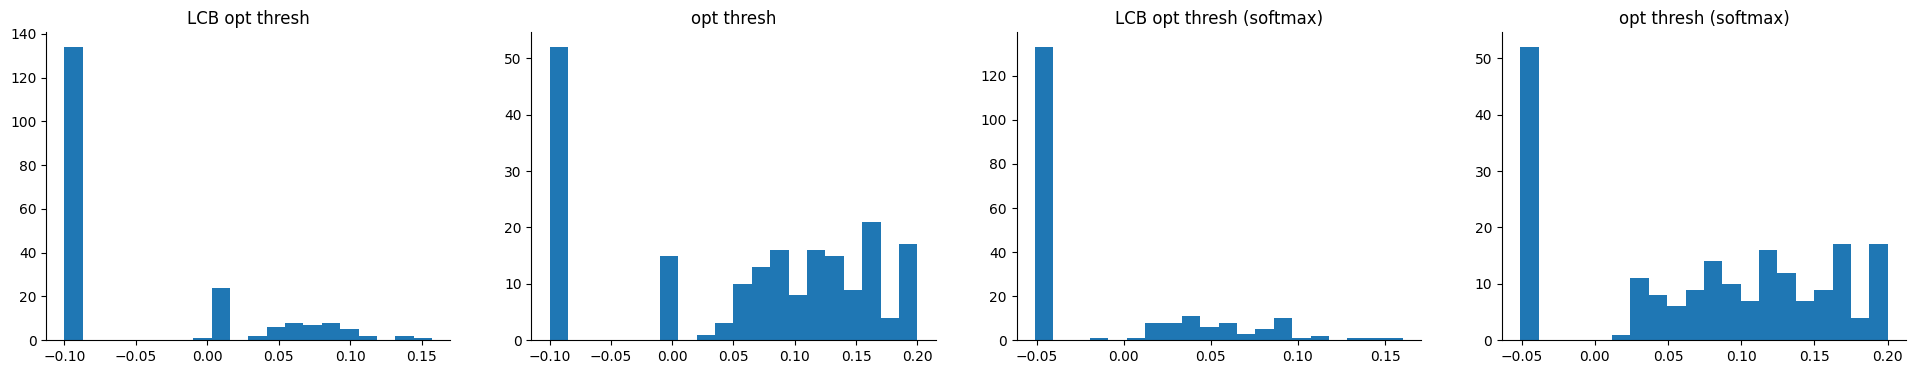

In [25]:
fig, ax = plt.subplots(1,4,figsize=(24,4))

ax[0].hist(all_lcb_opt_threshes, bins=20)
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_title("LCB opt thresh")

ax[1].hist(all_opt_threshes, bins=20)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title("opt thresh")

ax[2].hist(all_softmax_lcb_opt_threshes, bins=20)
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].set_title("LCB opt thresh (softmax)")

ax[3].hist(all_softmax_opt_threshes, bins=20)
ax[3].spines[['right', 'top']].set_visible(False)
ax[3].set_title("opt thresh (softmax)")

plt.show()

#### Constant

In [26]:
theta = 0
tau = 0.1
thresh_space = np.linspace(-0.1,0.3,50)
n_test = 400

score_fn = lambda x: x[:,0] + x[:,1] - x[:,2] - x[:,3]

In [27]:
# Calculate the truth
all_asy_utility = []
for thresh in thresh_space:
    print("Processing thresh = {}".format(thresh))
    region_fn = lambda x: score_fn(x) > thresh
    asy_utility, _, _ = calc_empirical_exp_utility(region_fn, theta, n_test, tau=tau)
    all_asy_utility.append(asy_utility)
all_asy_utility = np.array(all_asy_utility)

Processing thresh = -0.1
Processing thresh = -0.09183673469387756
Processing thresh = -0.0836734693877551
Processing thresh = -0.07551020408163266
Processing thresh = -0.0673469387755102
Processing thresh = -0.05918367346938776
Processing thresh = -0.05102040816326531
Processing thresh = -0.04285714285714286
Processing thresh = -0.03469387755102041
Processing thresh = -0.026530612244897958
Processing thresh = -0.01836734693877551
Processing thresh = -0.010204081632653059
Processing thresh = -0.002040816326530609
Processing thresh = 0.006122448979591841
Processing thresh = 0.01428571428571429
Processing thresh = 0.02244897959183674
Processing thresh = 0.03061224489795919
Processing thresh = 0.038775510204081626
Processing thresh = 0.04693877551020409
Processing thresh = 0.05510204081632655
Processing thresh = 0.06326530612244899
Processing thresh = 0.07142857142857142
Processing thresh = 0.07959183673469389
Processing thresh = 0.08775510204081635
Processing thresh = 0.09591836734693879


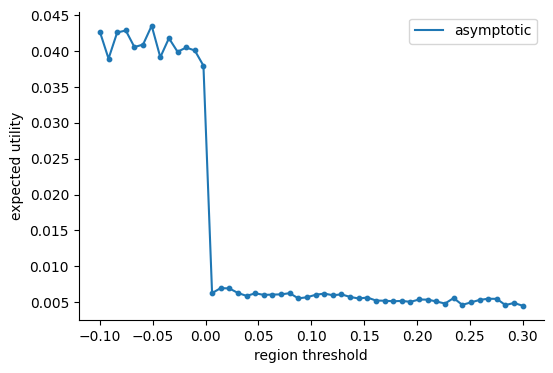

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(thresh_space, all_asy_utility, label="asymptotic")
ax.scatter(thresh_space, all_asy_utility, s=10)

ax.set_xlabel("region threshold")
ax.set_ylabel("expected utility")

ax.spines[['right', 'top']].set_visible(False)
ax.legend()

plt.show()

Large sample properties

In [29]:
n = 10000

In [30]:
X, Y = sample_dgp(n, theta)

In [31]:
exp_utility, all_boot_exp_utility = bootstrap_empirical_exp_utility(X,
                                                                    Y,
                                                                    score_fn,
                                                                    thresh_space,
                                                                    n_test)

In [32]:
opt_thresh = thresh_space[np.argmax(exp_utility)]
boot_opt_threshes = thresh_space[all_boot_exp_utility.argmax(axis=1)]
softmax_opt_thresh = soft_argmax(exp_utility, thresh_space, gamma * exp_utility.std())
boot_softmax_opt_thresh = soft_argmax(all_boot_exp_utility, thresh_space, gamma * exp_utility.std())

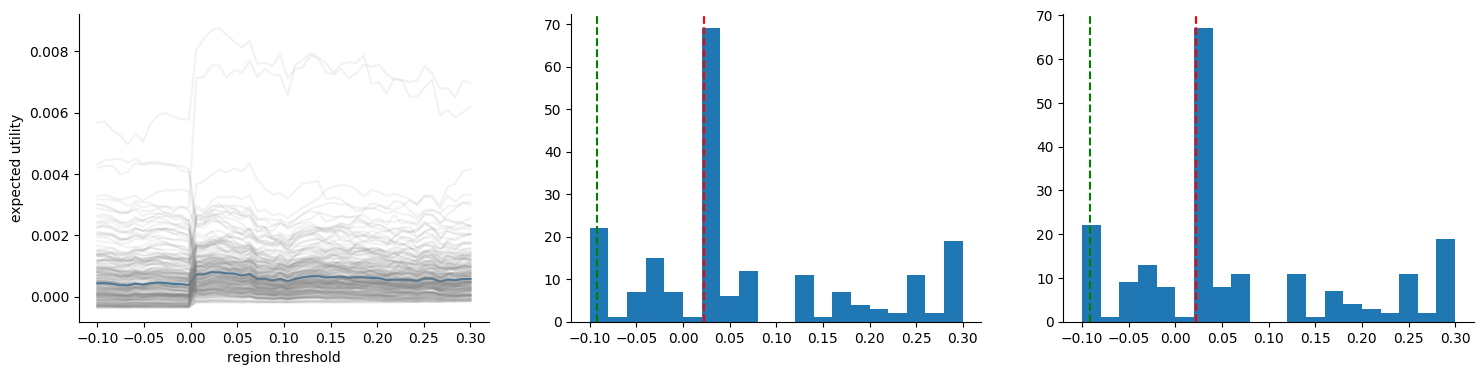

In [33]:
fig, ax = plt.subplots(1,3,figsize=(18,4))

ax[0].plot(thresh_space, exp_utility)
for boot_exp_utility in all_boot_exp_utility:
    ax[0].plot(thresh_space, boot_exp_utility, alpha=0.1, color="gray")

ax[0].set_xlabel("region threshold")
ax[0].set_ylabel("expected utility")
ax[0].spines[['right', 'top']].set_visible(False)

ax[1].hist(boot_opt_threshes, bins=20)
ax[1].axvline(opt_thresh, linestyle="--", color="red")
ax[1].axvline(np.quantile(boot_opt_threshes, 0.1), linestyle="--", color="green")
ax[1].spines[['right', 'top']].set_visible(False)

ax[2].hist(boot_softmax_opt_thresh, bins=20)
ax[2].axvline(softmax_opt_thresh, linestyle="--", color="red")
ax[2].axvline(np.quantile(boot_softmax_opt_thresh, 0.1), linestyle="--", color="green")
ax[2].spines[['right', 'top']].set_visible(False)

plt.show()

Small sample properties

In [34]:
n = 250

In [35]:
X, Y = sample_dgp(n, theta)

In [36]:
exp_utility, all_boot_exp_utility = bootstrap_empirical_exp_utility(X,
                                                                    Y,
                                                                    score_fn,
                                                                    thresh_space,
                                                                    n_test)

In [37]:
opt_thresh = thresh_space[np.argmax(exp_utility)]
boot_opt_threshes = thresh_space[all_boot_exp_utility.argmax(axis=1)]
softmax_opt_thresh = soft_argmax(exp_utility, thresh_space, gamma * exp_utility.std())
boot_softmax_opt_thresh = soft_argmax(all_boot_exp_utility, thresh_space, gamma * exp_utility.std())

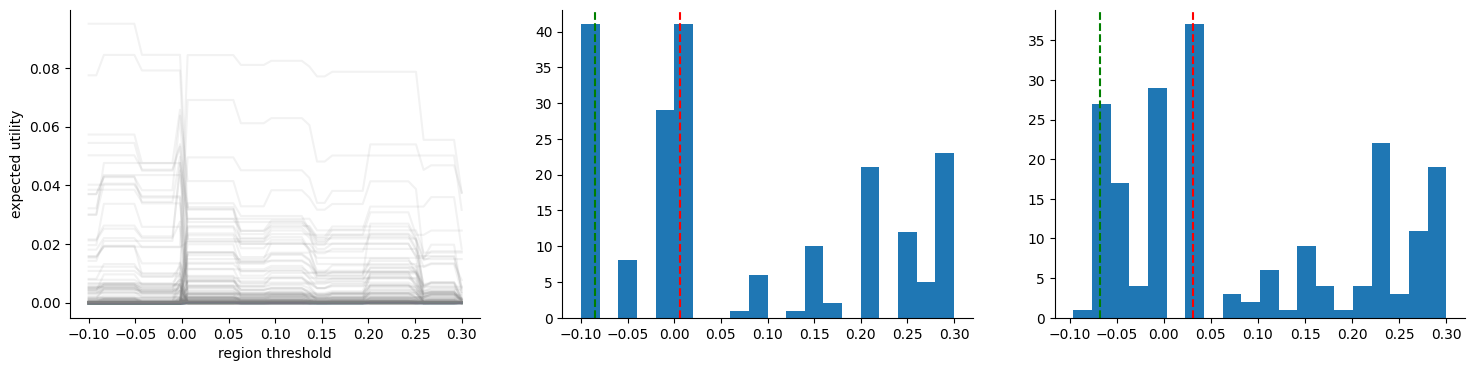

In [38]:
fig, ax = plt.subplots(1,3,figsize=(18,4))

ax[0].plot(thresh_space, exp_utility)
for boot_exp_utility in all_boot_exp_utility:
    ax[0].plot(thresh_space, boot_exp_utility, alpha=0.1, color="gray")

ax[0].set_xlabel("region threshold")
ax[0].set_ylabel("expected utility")
ax[0].spines[['right', 'top']].set_visible(False)

ax[1].hist(boot_opt_threshes, bins=20)
ax[1].axvline(opt_thresh, linestyle="--", color="red")
ax[1].axvline(np.quantile(boot_opt_threshes, 0.1), linestyle="--", color="green")
ax[1].spines[['right', 'top']].set_visible(False)

ax[2].hist(boot_softmax_opt_thresh, bins=20)
ax[2].axvline(softmax_opt_thresh, linestyle="--", color="red")
ax[2].axvline(np.quantile(boot_softmax_opt_thresh, 0.1), linestyle="--", color="green")
ax[2].spines[['right', 'top']].set_visible(False)

plt.show()

Small sample properties (distributional)

In [ ]:
all_opt_threshes = []
all_lcb_opt_threshes = []
all_softmax_opt_threshes = []
all_softmax_lcb_opt_threshes = []
for _ in range(200):
    if _ % 10 == 0:
        print("Progress = {}".format(_))
    X, Y = sample_dgp(n, theta)
    exp_utility, all_boot_exp_utility = bootstrap_empirical_exp_utility(X,
                                                                        Y,
                                                                        score_fn,
                                                                        thresh_space,
                                                                        n_test)
    # Calculate optima
    opt_thresh = thresh_space[np.argmax(exp_utility)]
    boot_opt_threshes = thresh_space[all_boot_exp_utility.argmax(axis=1)]
    # Calculate softmax optima
    softmax_opt_thresh = soft_argmax(exp_utility, thresh_space, gamma * exp_utility.std())
    boot_softmax_opt_thresh = soft_argmax(all_boot_exp_utility, thresh_space, gamma * exp_utility.std())
    # Save
    all_opt_threshes.append(opt_thresh)
    all_lcb_opt_threshes.append(np.quantile(boot_opt_threshes, 0.1))
    all_softmax_opt_threshes.append(softmax_opt_thresh)
    all_softmax_lcb_opt_threshes.append(np.quantile(boot_softmax_opt_thresh, 0.1))
all_opt_threshes = np.array(all_opt_threshes)
all_lcb_opt_threshes = np.array(all_lcb_opt_threshes)
all_softmax_opt_threshes = np.array(all_softmax_opt_threshes)
all_softmax_lcb_opt_threshes = np.array(all_softmax_lcb_opt_threshes)

Progress = 0
Progress = 10
Progress = 20
Progress = 30
Progress = 40


In [ ]:
fig, ax = plt.subplots(1,4,figsize=(24,4))

ax[0].hist(all_lcb_opt_threshes, bins=20)
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_title("LCB opt thresh")

ax[1].hist(all_opt_threshes, bins=20)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title("opt thresh")

ax[2].hist(all_softmax_lcb_opt_threshes, bins=20)
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].set_title("LCB opt thresh (softmax)")

ax[3].hist(all_softmax_opt_threshes, bins=20)
ax[3].spines[['right', 'top']].set_visible(False)
ax[3].set_title("opt thresh (softmax)")

plt.show()

Notes:
- To actually leverage the Gaussian prior on the softmax I need to use a symmetric grid (in fact, I actually need to integrate over the entire real line, but a symmetric grid will yield a better approximation).
- Things should be better off when the function is not as discontinuous, which is probably more true in practice since I'll be using continuous scores.